In [ ]:
import pandas as pd
import numpy as np
import yaml
from importlib import resources as impresources
from recurrent_health_events_prediction import configs

from recurrent_health_events_prediction.model.NextEventPredictionModel import (
    NextEventPredictionModel,
)
from recurrent_health_events_prediction.training.utils import summarize_search_results
from recurrent_health_events_prediction.training.utils_survival import (
    train_next_event_survival_model_rand_search_cv,
    save_coef_lifelines_plot,
)
from recurrent_health_events_prediction.model.model_types import SurvivalModelType

## Import Configs and Load Preprocessed Data

In [61]:
with open((impresources.files(configs) / "model_config.yaml")) as f:
    model_config = yaml.safe_load(f)
with open((impresources.files(configs) / "data_config.yaml")) as f:
    data_config = yaml.safe_load(f)

In [62]:
training_data_config = data_config["training_data"]["mimic"]
next_event_model_config = model_config["mimic"]["next_event_model"]

In [63]:
next_event_model_config

{'last_event_based': {'model_name': 'survival_model',
  'model_type': None,
  'save_model_path': '/workspaces/msc-thesis-recurrent-health-modeling/_models/mimic/survival',
  'strata_col': None,
  'event_col': 'READMISSION_EVENT',
  'event_id_col': 'HADM_ID',
  'duration_col': 'EVENT_DURATION',
  'cluster_col': 'SUBJECT_ID',
  'features': ['NUM_PREV_HOSPITALIZATIONS',
   'LOG_DAYS_IN_ICU',
   'CHARLSON_INDEX']},
 'hmm_based': {'model_name': 'cph_model_hmm_cov_based',
  'model_type': 'cox_ph',
  'save_model_path': '/workspaces/msc-thesis-recurrent-health-modeling/_models/mimic/hmm_survival',
  'strata_col': None,
  'event_col': 'READMISSION_EVENT',
  'event_id_col': 'HADM_ID',
  'duration_col': 'EVENT_DURATION',
  'cluster_col': 'SUBJECT_ID',
  'features': ['NUM_PREV_HOSPITALIZATIONS',
   'LOG_DAYS_IN_ICU',
   'CHARLSON_INDEX']}}

In [5]:
training_data_path = training_data_config["preprocessed_path"]
subdir = "/mimic_cleaned_v1"
training_data_path += subdir
print("Loading training data from:", training_data_path)
last_events_df = pd.read_csv(training_data_path + "/last_events.csv")
all_events_df = pd.read_csv(training_data_path + "/all_events.csv")

Loading training data from: /workspaces/msc-thesis-recurrent-health-modeling/data/mimic-iii-preprocessed/copd_hf_renal_diabetes/mimic_cleaned_v1


### Events Distribution

In [6]:
last_events_df["NEXT_ADMISSION_TYPE"].value_counts()

NEXT_ADMISSION_TYPE
EMERGENCY    3833
URGENT         63
Name: count, dtype: int64

In [7]:
all_events_df["NEXT_ADMISSION_TYPE"].value_counts()

NEXT_ADMISSION_TYPE
EMERGENCY    7348
ELECTIVE      104
URGENT        103
Name: count, dtype: int64

In [ ]:
import plotly.express as px

event_type_censoring_color_map = {
    "Event Ocurred": px.colors.qualitative.Plotly[0],
    "Censored": px.colors.qualitative.Plotly[4],
}

# Plot the distribution of EVENT_DURATION
fig = px.histogram(
    last_events_df,
    x="EVENT_DURATION",
    nbins=50,
    marginal="violin",
    opacity=0.7,
    color="READMISSION_EVENT",
    labels={
        "EVENT_DURATION": "Duration (days)",
        "READMISSION_EVENT": "Readmission Event",
    },
    category_orders={"READMISSION_EVENT": [0, 1]},
)
fig.update_layout(
    title="Distribution of Event Duration - Last Events", yaxis_title="Count"
)
fig.show()

print(px.colors.qualitative.Plotly[2])

#00CC96


In [ ]:
import plotly.express as px

# Plot the distribution of Previos Number of Hospitalizations
fig = px.histogram(
    last_events_df,
    x="NUM_PREV_HOSPITALIZATIONS",
    nbins=50,
    marginal="violin",
    opacity=0.7,
    color="READMISSION_EVENT",
    labels={
        "NUM_PREV_HOSPITALIZATIONS": "Number of Previous Hospitalizations",
        "READMISSION_EVENT": "Readmission Event",
    },
)
fig.update_layout(
    title="Distribution of Number of Previous Hospitalizations - Last Events",
    yaxis_title="Count",
)
fig.show()

In [ ]:
import plotly.express as px

total_hospitalizations = (
    last_events_df.groupby("SUBJECT_ID")["TOTAL_HOSPITALIZATIONS"].first().reset_index()
)
# Plot the distribution of Previos Number of Hospitalizations
fig = px.histogram(
    total_hospitalizations,
    x="TOTAL_HOSPITALIZATIONS",
    marginal="violin",
    labels={"TOTAL_HOSPITALIZATIONS": "Total Number of Hospitalizations"},
)
fig.update_layout(
    title="Distribution of Total Number of Hospitalizations - Last Events",
    yaxis_title="Count",
)
fig.show()

In [ ]:
import plotly.express as px

# Map values for better readability
readmission_mapping = {
    0: "No readmission within 120 days (censoring)",
    1: "Readmission within 120 days",
}
last_events_df["READMISSION_EVENT_MAPPED"] = last_events_df["READMISSION_EVENT"].map(
    readmission_mapping
)

# Create the pie chart
px.pie(
    last_events_df,
    names="READMISSION_EVENT_MAPPED",
    title="Readmission Event and Censoring Fractions - Last Events",
    labels={"READMISSION_EVENT_MAPPED": "Readmission Event"},
    color_discrete_sequence=["blue", "red"],
    width=900,
).show()

In [12]:
last_events_df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'ADMISSION_TYPE',
       'ETHNICITY', 'DISCHARGE_LOCATION', 'INSURANCE', 'HOSPITALIZATION_DAYS',
       'NUM_COMORBIDITIES', 'TYPES_COMORBIDITIES', 'HAS_DIABETES', 'HAS_COPD',
       'HAS_CONGESTIVE_HF', 'NEXT_ADMISSION_TYPE', 'NUM_PREV_HOSPITALIZATIONS',
       'PREV_DISCHTIME', 'NEXT_ADMITTIME', 'DAYS_SINCE_LAST_HOSPITALIZATION',
       'DAYS_UNTIL_NEXT_HOSPITALIZATION',
       'LOG_DAYS_SINCE_LAST_HOSPITALIZATION',
       'LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION', 'PREV_READMISSION_30_DAYS',
       'READMISSION_30_DAYS', 'READM_30_DAYS_PAST_MEAN',
       'READM_30_DAYS_PAST_SUM', 'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEAN',
       'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN',
       'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD', 'TOTAL_HOSPITALIZATIONS',
       'DAYS_IN_ICU', 'NUM_DRUGS', 'NUM_PROCEDURES', 'GENDER', 'DOB', 'DOD',
       'DOD_HOSP', 'AGE', 'CHARLSON_INDEX', 'FIRST_ADMITTIME',
       'LAST_DISCHTIME', 'PARTICIPATION_DAYS', 'TOTAL_PARTICI

In [ ]:
import plotly.express as px

# Map values for better readability
readmission_mapping = {
    0: "No readmission within 30 days",
    1: "Readmission within 30 days",
}
last_events_df["READMISSION_EVENT_MAPPED"] = last_events_df["READMISSION_30_DAYS"].map(
    readmission_mapping
)

# Create the pie chart
px.pie(
    last_events_df,
    names="READMISSION_EVENT_MAPPED",
    title="Readmission Event 30 Days - Last Events",
    labels={"READMISSION_EVENT_MAPPED": "Readmission Event"},
    color_discrete_sequence=["blue", "red"],
    width=900,
).show()

last_events_df.drop(columns=["READMISSION_EVENT_MAPPED"], inplace=True)

In [14]:
print("Final number of unique subjects: ", last_events_df.SUBJECT_ID.nunique())
print("Final number of events: ", len(last_events_df))

Final number of unique subjects:  10770
Final number of events:  10770


## Survival Models

Traditional survival models. Only the last events are used for training (except for Cox PH with SE). Time to next event is the target variable.

In [15]:
evaluation_times = [15, 30, 60, 90, 100]

In [ ]:
last_events_df["EVENT_DURATION"].describe()

count    10770.000000
mean       105.521847
std         34.305580
min          1.004167
25%        120.000000
50%        120.000000
75%        120.000000
max        120.000000
Name: EVENT_DURATION, dtype: float64

### Train-Test Split

In [17]:
last_events_df["RANDOM_FEATURE"] = np.random.rand(len(last_events_df))
all_events_df["RANDOM_FEATURE"] = np.random.rand(len(all_events_df))

In [ ]:
from sklearn.discriminant_analysis import StandardScaler
from recurrent_health_events_prediction.training.utils_survival import (
    train_test_split_survival_data,
)

X_train, X_test = train_test_split_survival_data(
    last_events_df,
    duration_col="EVENT_DURATION",
    event_col="READMISSION_EVENT",
    q_bins=1,
)

features_to_scale = [
    "NUM_PREV_HOSPITALIZATIONS",
    "LOG_NUM_PREV_HOSPITALIZATIONS",
    "LOG_HOSPITALIZATION_DAYS",
    "LOG_DAYS_IN_ICU",
    "AGE",
    "CHARLSON_INDEX",
    "LOG_DAYS_SINCE_LAST_HOSPITALIZATION",
    "READM_30_DAYS_PAST_MEAN",
    "READM_30_DAYS_PAST_SUM",
    "NUM_COMORBIDITIES",
    "NUM_PROCEDURES",
    "NUM_DRUGS",
    "RANDOM_FEATURE",
]

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

scaler = StandardScaler()

X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

Train set event composition:
 READMISSION_EVENT
0    0.825093
1    0.174907
Name: count, dtype: float64
Test set event composition:
 READMISSION_EVENT
0    0.832405
1    0.167595
Name: count, dtype: float64
Train average event duration: 105.42915449615703
Test average event duration: 105.89261483802744


In [ ]:
X_train_all_events, X_test_all_events = train_test_split_survival_data(
    all_events_df,
    duration_col="EVENT_DURATION",
    event_col="READMISSION_EVENT",
    q_bins=1,
)

X_train_scaled_all_events = X_train_all_events.copy()
X_test_scaled_all_events = X_test_all_events.copy()

scaler = StandardScaler()

X_train_scaled_all_events[features_to_scale] = scaler.fit_transform(
    X_train_all_events[features_to_scale]
)
X_test_scaled_all_events[features_to_scale] = scaler.transform(
    X_test_all_events[features_to_scale]
)

Train set event composition:
 READMISSION_EVENT
0    0.739669
1    0.260331
Name: count, dtype: float64
Test set event composition:
 READMISSION_EVENT
0    0.75052
1    0.24948
Name: count, dtype: float64
Train average event duration: 98.50294641052295
Test average event duration: 99.76483574921076


### Feature Selection

In [21]:
last_events_df.isna().sum()

SUBJECT_ID                                 0
HADM_ID                                    0
ADMITTIME                                  0
DISCHTIME                                  0
ADMISSION_TYPE                             0
ETHNICITY                                  0
DISCHARGE_LOCATION                         0
INSURANCE                                  0
HOSPITALIZATION_DAYS                       0
NUM_COMORBIDITIES                          0
TYPES_COMORBIDITIES                        0
HAS_DIABETES                               0
HAS_COPD                                   0
HAS_CONGESTIVE_HF                          0
NEXT_ADMISSION_TYPE                     6874
NUM_PREV_HOSPITALIZATIONS                  0
PREV_DISCHTIME                          9166
NEXT_ADMITTIME                          6874
DAYS_SINCE_LAST_HOSPITALIZATION         9166
DAYS_UNTIL_NEXT_HOSPITALIZATION         6874
LOG_DAYS_SINCE_LAST_HOSPITALIZATION     9166
LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION     6874
PREV_READM

In [25]:
for col in [
    "LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN",
    "LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD",
    "LOG_DAYS_SINCE_LAST_HOSPITALIZATION",
    "READM_30_DAYS_PAST_MEAN",
    "READM_30_DAYS_PAST_SUM",
]:
    print(f"Filling NaNs in {col} with 0")
    X_train_scaled[col] = X_train_scaled[col].fillna(0)
    X_test_scaled[col] = X_test_scaled[col].fillna(0)
    X_train_scaled_all_events[col] = X_train_scaled_all_events[col].fillna(0)
    X_test_scaled_all_events[col] = X_test_scaled_all_events[col].fillna(0)

Filling NaNs in LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN with 0
Filling NaNs in LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD with 0
Filling NaNs in LOG_DAYS_SINCE_LAST_HOSPITALIZATION with 0
Filling NaNs in READM_30_DAYS_PAST_MEAN with 0
Filling NaNs in READM_30_DAYS_PAST_SUM with 0


In [26]:
from lifelines import CoxPHFitter

features = [
    "LOG_NUM_PREV_HOSPITALIZATIONS",
    "LOG_HOSPITALIZATION_DAYS",
    "LOG_DAYS_IN_ICU",
    "NUM_COMORBIDITIES",
    "NUM_PROCEDURES",
    "NUM_DRUGS",
    "AGE",
    "CHARLSON_INDEX",
    "HAS_COPD",
    "HAS_DIABETES",
    "HAS_CONGESTIVE_HF",
    "LOG_DAYS_SINCE_LAST_HOSPITALIZATION",
    "PREV_READMISSION_30_DAYS",
    "READM_30_DAYS_PAST_MEAN",
    "READM_30_DAYS_PAST_SUM",
    "HAS_DIABETES",
    "HAS_COPD",
    "RANDOM_FEATURE",
]

significant_features = []
for col in features:
    cph = CoxPHFitter()
    cph.fit(
        X_train_scaled[[col, "EVENT_DURATION", "READMISSION_EVENT"]],
        "EVENT_DURATION",
        event_col="READMISSION_EVENT",
    )
    summary = cph.summary
    p_value = summary.loc[col, "p"]
    if p_value < 0.05:
        significant_features.append(col)
    print(f"{col}: HR={summary.loc[col, 'exp(coef)']:.2f}, p={p_value:.3g}")

print("Significant features:", significant_features)

LOG_NUM_PREV_HOSPITALIZATIONS: HR=1.61, p=1.07e-266
LOG_HOSPITALIZATION_DAYS: HR=1.27, p=1.39e-21
LOG_DAYS_IN_ICU: HR=1.23, p=9.76e-18
NUM_COMORBIDITIES: HR=1.23, p=3.64e-17
NUM_PROCEDURES: HR=1.01, p=0.689
NUM_DRUGS: HR=1.18, p=2.66e-11
AGE: HR=1.11, p=5.5e-05
CHARLSON_INDEX: HR=1.32, p=3.04e-30
HAS_COPD: HR=0.90, p=0.0542
HAS_DIABETES: HR=1.09, p=0.107
HAS_CONGESTIVE_HF: HR=1.13, p=0.0205
LOG_DAYS_SINCE_LAST_HOSPITALIZATION: HR=0.56, p=9.79e-19
PREV_READMISSION_30_DAYS: HR=3.29, p=6.73e-296
READM_30_DAYS_PAST_MEAN: HR=1.62, p=4.42e-18
READM_30_DAYS_PAST_SUM: HR=1.35, p=1.16e-15
HAS_DIABETES: HR=1.09, p=0.107
HAS_COPD: HR=0.90, p=0.0542
RANDOM_FEATURE: HR=0.97, p=0.178
Significant features: ['LOG_NUM_PREV_HOSPITALIZATIONS', 'LOG_HOSPITALIZATION_DAYS', 'LOG_DAYS_IN_ICU', 'NUM_COMORBIDITIES', 'NUM_DRUGS', 'AGE', 'CHARLSON_INDEX', 'HAS_CONGESTIVE_HF', 'LOG_DAYS_SINCE_LAST_HOSPITALIZATION', 'PREV_READMISSION_30_DAYS', 'READM_30_DAYS_PAST_MEAN', 'READM_30_DAYS_PAST_SUM']


In [27]:
final_features = [
    "AGE",
    "READM_30_DAYS_PAST_MEAN",
    "PREV_READMISSION_30_DAYS",
    "CHARLSON_INDEX",
    "LOG_NUM_PREV_HOSPITALIZATIONS",
    "LOG_DAYS_IN_ICU",
    "NUM_DRUGS",
    "HAS_DIABETES",
    "HAS_COPD",
]

### Models

In [28]:
next_event_model_config["last_event_based"]["features"] = final_features.copy()
next_event_model_config["last_event_based"]["strata_col"] = None
features = next_event_model_config["last_event_based"]["features"]
print("Features used in the model:", features)

Features used in the model: ['AGE', 'READM_30_DAYS_PAST_MEAN', 'PREV_READMISSION_30_DAYS', 'CHARLSON_INDEX', 'LOG_NUM_PREV_HOSPITALIZATIONS', 'LOG_DAYS_IN_ICU', 'NUM_DRUGS', 'HAS_DIABETES', 'HAS_COPD']


In [29]:
from recurrent_health_events_prediction.training.utils_survival import build_strata_col

strata_col = build_strata_col(
    X_train_scaled,
    duration_col="EVENT_DURATION",
    event_col="READMISSION_EVENT",
    q_bins=1,
)
strata_col_all_events = build_strata_col(
    X_train_scaled_all_events,
    duration_col="EVENT_DURATION",
    event_col="READMISSION_EVENT",
    q_bins=1,
)

In [30]:
param_lifelines_grid = {
    "penalizer": np.linspace(0.01, 0.2, 20),
    "l1_ratio": np.linspace(0.01, 1, 20),
}

param_grid_gbm_survival = {
    "learning_rate": np.linspace(0.01, 0.2, 10),
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5, 6, 7, 8],
}

n_iter = 10
random_state = 42
cv = 5

#### Data

In [31]:
X_train[
    ["SUBJECT_ID", "HADM_ID", "EVENT_DURATION", "READMISSION_EVENT"] + features
].head()

SUBJECT_ID  HADM_ID  EVENT_DURATION  READMISSION_EVENT  AGE  \
0       27062   107808           120.0                  0   41   
1       18839   152908           120.0                  0   83   
2       63777   134801           120.0                  0   69   
3       68513   170638           120.0                  0   83   
4       44630   151362           120.0                  0   67   

   READM_30_DAYS_PAST_MEAN  PREV_READMISSION_30_DAYS  CHARLSON_INDEX  \
0                      NaN                        -1               4   
1                      NaN                        -1              10   
2                      NaN                        -1              12   
3                      NaN                        -1              10   
4                      NaN                        -1               4   

   LOG_NUM_PREV_HOSPITALIZATIONS  LOG_DAYS_IN_ICU  NUM_DRUGS  HAS_DIABETES  \
0                            0.0         0.959590         22          True   
1                            0.0         1.538454         43          True   
2                            0.0         2.832068         59         False   
3                            0.0         0.840219         21          True   
4                            0.0         2.063446         53          True   

   HAS_COPD  
0     False  
1     False  
2      True  
3     False  
4      True

In [32]:
X_test[
    ["SUBJECT_ID", "HADM_ID", "EVENT_DURATION", "READMISSION_EVENT"] + features
].head()

SUBJECT_ID  HADM_ID  EVENT_DURATION  READMISSION_EVENT  AGE  \
1252        6529   133334      120.000000                  0   49   
4432       23131   178742      120.000000                  0   63   
686         3555   172469      120.000000                  0   50   
8164       64043   140534      120.000000                  0   59   
3640       19069   106533       88.151389                  1   30   

      READM_30_DAYS_PAST_MEAN  PREV_READMISSION_30_DAYS  CHARLSON_INDEX  \
1252                      NaN                        -1               2   
4432                      NaN                        -1               4   
686                       NaN                        -1               3   
8164                      NaN                        -1               5   
3640                      NaN                        -1               1   

      LOG_NUM_PREV_HOSPITALIZATIONS  LOG_DAYS_IN_ICU  NUM_DRUGS  HAS_DIABETES  \
1252                            0.0         0.656026         25          True   
4432                            0.0         2.393564         45         False   
686                             0.0         1.376320         58          True   
8164                            0.0         0.770183         38          True   
3640                            0.0         1.051279         28         False   

      HAS_COPD  
1252      True  
4432      True  
686      False  
8164     False  
3640     False

In [33]:
X_train_scaled[
    ["SUBJECT_ID", "HADM_ID", "EVENT_DURATION", "READMISSION_EVENT"] + features
].describe()

SUBJECT_ID       HADM_ID  EVENT_DURATION  READMISSION_EVENT  \
count   8616.000000    8616.00000     8616.000000        8616.000000   
mean   38190.235492  150443.10968      105.429154           0.174907   
std    29365.574610   29034.87535       34.423401           0.379910   
min       21.000000  100006.00000        1.022917           0.000000   
25%    13942.500000  125232.50000      120.000000           0.000000   
50%    27741.500000  150566.00000      120.000000           0.000000   
75%    62740.000000  175595.50000      120.000000           0.000000   
max    99982.000000  199994.00000      120.000000           1.000000   

                AGE  READM_30_DAYS_PAST_MEAN  PREV_READMISSION_30_DAYS  \
count  8.616000e+03             8.616000e+03               8616.000000   
mean   1.468958e-16            -9.071460e-18                 -0.811281   
std    1.000058e+00             3.856088e-01                  0.482923   
min   -2.672126e+00            -6.774279e-01                 -1.000000   
25%   -6.183681e-01             0.000000e+00                 -1.000000   
50%    2.031352e-01             0.000000e+00                 -1.000000   
75%    7.899233e-01             0.000000e+00                 -1.000000   
max    1.494069e+00             2.025529e+00                  1.000000   

       CHARLSON_INDEX  LOG_NUM_PREV_HOSPITALIZATIONS  LOG_DAYS_IN_ICU  \
count    8.616000e+03                   8.616000e+03     8.616000e+03   
mean    -1.033940e-16                  -1.502976e-16    -5.504727e-16   
std      1.000058e+00                   1.000058e+00     1.000058e+00   
min     -2.062148e+00                  -3.771447e-01    -1.961534e+00   
25%     -8.201020e-01                  -3.771447e-01    -7.798863e-01   
50%      7.928566e-03                  -3.771447e-01    -2.333852e-01   
75%      8.359591e-01                  -3.771447e-01     5.467010e-01   
max      4.562097e+00                   8.049825e+00     5.200704e+00   

          NUM_DRUGS  
count  8.616000e+03  
mean   1.057650e-16  
std    1.000058e+00  
min   -1.844429e+00  
25%   -6.096464e-01  
50%   -9.515368e-02  
75%    6.765854e-01  
max    5.667165e+00

#### Kaplan Meyer

In [34]:
# Initialize the model with the configuration
next_event_model_km = NextEventPredictionModel(
    next_event_model_config["last_event_based"],
    model_type=SurvivalModelType.KAPLAN_MEIER,
)
next_event_model_km.model_name = "Kaplan Meier Estimator"

In [35]:
next_event_model_km.fit(X_train)

In [36]:
print("Median survival time:", next_event_model_km.model.median_survival_time_)

Median survival time: inf


In [38]:
fig = next_event_model_km.plot_survival_function(
    X_test, duration_col="EVENT_DURATION", event_col="READMISSION_EVENT"
)

In [39]:
next_event_model_km.evaluate_c_index(X_train, save_metric=True)

0.5

##### Evaluate Test Set

In [40]:
from recurrent_health_events_prediction.training.utils_survival import evaluate_model

# Evaluate the model on the test set
evaluate_model(
    next_event_model_km,
    X_train,
    X_test,
    evaluation_times=evaluation_times,
    evaluation_set="test",
)

Test C-index for Kaplan Meier Estimator: 0.5000


Mean AUC-ROC for Kaplan Meier Estimator: 0.5000


#### Cox Proportional Hazard Model - Last Events 

In [41]:
cph_model_config = next_event_model_config["last_event_based"].copy()
cph_model_model_name = "Cox Proportional Hazard Model"
cph_model_config["model_type"] = SurvivalModelType.COX_PH
cph_model_config["cluster_col"] = None
cph_model_config["strata_col"] = None
cph_model_config["model_name"] = "Cox Proportional Hazard Model"

In [42]:
from recurrent_health_events_prediction.training.utils_survival import (
    train_next_event_survival_model_rand_search_cv,
)

random_search_cph = train_next_event_survival_model_rand_search_cv(
    training_df=X_train_scaled,
    model_config=cph_model_config,
    strata_col_s=strata_col,
    param_grid=param_lifelines_grid,
    n_iter=n_iter,
    random_state=random_state,
    cv=cv,
)

cph_model = random_search_cph.best_estimator_
cph_model

NextEventSurvivalWrapper(columns_order=['AGE', 'READM_30_DAYS_PAST_MEAN',
                                        'PREV_READMISSION_30_DAYS',
                                        'CHARLSON_INDEX',
                                        'LOG_NUM_PREV_HOSPITALIZATIONS',
                                        'LOG_DAYS_IN_ICU', 'NUM_DRUGS',
                                        'HAS_DIABETES', 'HAS_COPD',
                                        'EVENT_DURATION', 'READMISSION_EVENT'],
                         model_config={'cluster_col': None,
                                       'duration_col': 'EVENT_DURATION',
                                       'event_col': 'READMISSION_EVENT',
                                       'event_id_c...
                                                     'Model',
                                       'model_params': {'l1_ratio': np.float64(0.21842105263157896),
                                                        'penalizer': np.float64(0.05)},
                                       'model_type': <SurvivalModelType.COX_PH: 'cox_ph'>,
                                       'save_model_path': '/workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/survival',
                                       'strata_col': None},
                         model_params={'l1_ratio': np.float64(0.21842105263157896),
                                       'penalizer': np.float64(0.05)})

In [43]:
search_results_cph = summarize_search_results(
    random_search_cph, model_name=cph_model_config["model_name"]
)

10 candidates of Cox proportional hazard model trained and validated with cross-validation on 5 folds.
Best parameters: {'model_params': {'penalizer': np.float64(0.05), 'l1_ratio': np.float64(0.21842105263157896)}}
Validation Score - Cox proportional hazard model: 0.719 ± 0.007


<lifelines.CoxPHFitter: fitted with 8616 total observations, 7109 right-censored observations>
             duration col = 'EVENT_DURATION'
                event col = 'READMISSION_EVENT'
                penalizer = 0.05
                 l1 ratio = 0.21842105263157896
      baseline estimation = breslow
   number of observations = 8616
number of events observed = 1507
   partial log-likelihood = -13049.89
         time fit was run = 2025-10-04 19:04:51 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
AGE                            0.00      1.00      0.00           -0.00            0.00                1.00                1.00
READM_30_DAYS_PAST_MEAN       -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
PREV_READMISSION_30_DAYS       0.75      2.12      0.05            0.66            0.85                1.93                2.33
CHARLSON_INDEX                 0.14      1.15      0.02            0.09            0.18                1.10                1.20
LOG_NUM_PREV_HOSPITALIZATIONS  0.20      1.22      0.02            0.15            0.24                1.17                1.28
LOG_DAYS_IN_ICU                0.12      1.13      0.03            0.07            0.17                1.07                1.19
NUM_DRUGS                      0.03      1.03      0.03           -0.02            0.08                0.98                1.09
HAS_DIABETES                  -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
HAS_COPD                      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00

                               cmp to     z      p  -log2(p)
covariate                                                   
AGE                              0.00  0.00   1.00      0.00
READM_30_DAYS_PAST_MEAN          0.00 -0.00   1.00      0.00
PREV_READMISSION_30_DAYS         0.00 15.42 <0.005    175.79
CHARLSON_INDEX                   0.00  6.11 <0.005     29.93
LOG_NUM_PREV_HOSPITALIZATIONS    0.00  8.74 <0.005     58.53
LOG_DAYS_IN_ICU                  0.00  4.79 <0.005     19.16
NUM_DRUGS                        0.00  1.20   0.23      2.12
HAS_DIABETES                     0.00 -0.00   1.00      0.00
HAS_COPD                         0.00 -0.00   1.00      0.00
---
Concordance = 0.72
Partial AIC = 26117.78
log-likelihood ratio test = 930.94 on 9 df
-log2(p) of ll-ratio test = 644.04

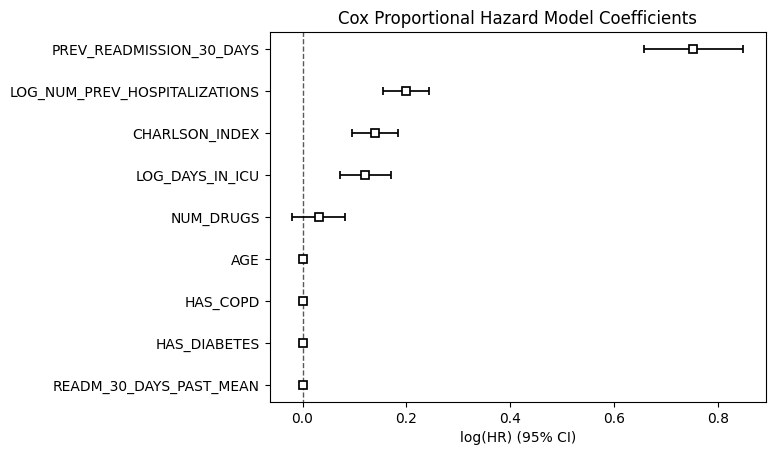

In [47]:
next_event_model_cph: NextEventPredictionModel = cph_model.model
next_event_model_cph.random_search_cv_results = search_results_cph
next_event_model_cph.model.print_summary()
ax = next_event_model_cph.model.plot()
save_coef_lifelines_plot(ax, next_event_model_cph)

In [48]:
import io
import contextlib

# 2. Capture stdout of check_assumptions
buffer = io.StringIO()
with contextlib.redirect_stdout(buffer):
    next_event_model_cph.model.check_assumptions(
        X_train_scaled[features + ["EVENT_DURATION", "READMISSION_EVENT"]],
        p_value_threshold=0.05,
    )

# 3. Get the full text output
check_assumptions_output = buffer.getvalue()

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 8616 total observations, 7109 right-censored observations>
         test_name = proportional_hazard_test

---
                                    test_statistic      p  -log2(p)
AGE                           km              0.00   0.99      0.01
                              rank            0.00   0.99      0.01
CHARLSON_INDEX                km              0.11   0.74      0.43
                              rank            0.11   0.74      0.43
HAS_COPD                      km              0.00   1.00      0.00
                              rank            0.00   1.00      0.00
HAS_DIABETES                  km              0.00   1.00      0.00
                              rank            0.00   1.00      0.00
LOG_DAYS_IN_ICU               km              1.60   0.21      2.28
                              rank            1.60   0.21      2.28
LOG_NUM_PREV_HOSPITALIZATIONS km              8.41 <0.005      8.06
                              rank            8.41 <0.005      8.06
NUM_DRUGS                     km              1.11   0.29      1.78
                              rank            1.11   0.29      1.78
PREV_READMISSION_30_DAYS      km              0.63   0.43      1.22
                              rank            0.63   0.43      1.22
READM_30_DAYS_PAST_MEAN       km              0.00   1.00      0.01
                              rank            0.00   1.00      0.01

In [50]:
fig = next_event_model_cph.plot_survival_function(
    X_train_scaled.iloc[:5],
    duration_col="EVENT_DURATION",
    n=3,
    event_col="READMISSION_EVENT",
)

In [51]:
fig = next_event_model_cph.plot_survival_function(
    X_test_scaled.iloc[:-4],
    duration_col="EVENT_DURATION",
    n=3,
    event_col="READMISSION_EVENT",
)

##### Evaluation Train Dataset

In [52]:
c_index_cox_ph = next_event_model_cph.evaluate_c_index(
    X_train_scaled, save_metric=True, evaluation_set="train"
)
print(f"Train C-index for Cox Proportional Hazards Model: {c_index_cox_ph:.4f}")

Train C-index for Cox Proportional Hazards Model: 0.7203


In [53]:
import matplotlib.pyplot as plt

from recurrent_health_events_prediction.training.utils_survival import (
    evaluate_model_around_specific_time,
)

# Predict survival probabilities for a specific time point
time_point = 30  # Example time point
predicted_probs_df, auc = evaluate_model_around_specific_time(
    next_event_model_cph, X_train_scaled, time_point, evaluation_set="train"
)

##### Evaluation Test Dataset

In [54]:
next_event_model_cph.evaluate_c_index(
    X_test_scaled, save_metric=True, evaluation_set="test"
)

0.7302640076826741

In [55]:
from recurrent_health_events_prediction.training.utils_survival import evaluate_model

# Evaluate the model on the test set
evaluate_model(
    next_event_model_cph,
    X_train_scaled,
    X_test_scaled,
    save_plots=True,
    evaluation_times=evaluation_times,
    evaluation_set="test",
)

Test C-index for Cox Proportional Hazard Model: 0.7303


Mean AUC-ROC for Cox Proportional Hazard Model: 0.7304


In [56]:
from recurrent_health_events_prediction.training.utils_survival import (
    evaluate_model_around_specific_time,
)

prob_df, auc_roc = evaluate_model_around_specific_time(
    next_event_model_cph,
    X_test_scaled,
    evaluation_time=30,
    save_plots=True,
    evaluation_set="test",
)

In [58]:
from recurrent_health_events_prediction.model.explainers import (
    explain_survival_model_prob,
)
from recurrent_health_events_prediction.training.train_traditional_survival_model import (
    plot_feature_importance_survival_model,
)
import shap
import matplotlib.pyplot as plt


def plot_survival_shap_summary(
    model: NextEventPredictionModel, X_train, X_explain, t=30, title=None
):
    """
    Generate and return a SHAP summary plot figure for survival probability at time `t`.

    Parameters:
    - model: trained NextEventPredictionModel
    - X_train: background data (usually training data)
    - X_explain: data to explain (e.g., test data or subset of training)
    - t: float, time at which to compute survival probabilities
    - title: optional plot title

    Returns:
    - fig: matplotlib.figure.Figure
    """
    feature_names = model.feature_names_in_
    # Ensure only selected features are used
    X_train_subset = X_train[feature_names].copy()
    X_explain_subset = X_explain[feature_names].copy()

    # Get SHAP values
    shap_values, _ = explain_survival_model_prob(
        model, X_train_subset, X_explain_subset, t=t
    )

    # Handle binary/multiclass shape
    if shap_values.ndim == 3:
        shap_values_to_plot = shap_values[:, :, 1]  # Class 1 survival
    else:
        shap_values_to_plot = shap_values

    # Create figure for SHAP plot
    fig = plt.figure()
    plt.title(title or f"SHAP Summary Plot (t={t})", pad=20)
    shap.summary_plot(
        shap_values_to_plot,
        X_explain_subset.astype(float),
        feature_names=feature_names,
        show=False,
    )  # Don't auto-show so we can return fig
    return fig

  0%|          | 0/100 [00:00<?, ?it/s]

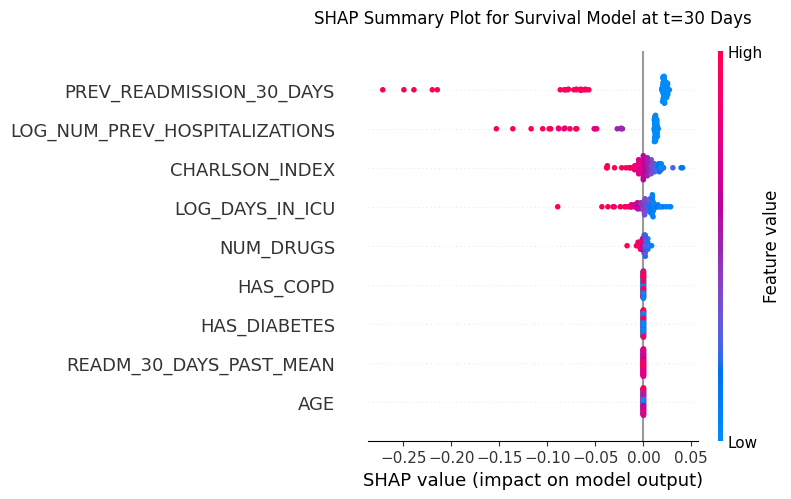

In [60]:
fig = plot_survival_shap_summary(
    next_event_model_cph,
    X_train_scaled.iloc[:100],
    X_test_scaled.iloc[:100],
    t=30,
    title="SHAP Summary Plot for Survival Model at t=30 Days",
)

#### Cox PH - All Events

In [ ]:
cph_se_model_config = next_event_model_config["last_event_based"].copy()
cph_se_model_config["model_name"] = "Cox Proportional Hazard Model with SE"
cph_se_model_config["model_type"] = SurvivalModelType.COX_PH
cph_se_model_config["cluster_col"] = "SUBJECT_ID"
cph_se_model_config["strata_col"] = None
cph_se_model_config

{'model_name': 'Cox Proportional Hazard Model with SE',
 'model_type': <SurvivalModelType.COX_PH: 'cox_ph'>,
 'save_model_path': '/workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/survival_last_event_based',
 'strata_col': None,
 'event_col': 'READMISSION_EVENT',
 'event_id_col': 'HADM_ID',
 'duration_col': 'EVENT_DURATION',
 'cluster_col': 'SUBJECT_ID',
 'features': ['AGE',
  'READM_30_DAYS_PAST_MEAN',
  'PREV_READMISSION_30_DAYS',
  'CHARLSON_INDEX',
  'LOG_NUM_PREV_HOSPITALIZATIONS',
  'LOG_DAYS_IN_ICU',
  'NUM_DRUGS',
  'HAS_DIABETES',
  'HAS_COPD']}

In [ ]:
X_train_scaled["READM_30_DAYS_PAST_MEAN"].describe()

count    1.352000e+03
mean     2.233585e-17
std      1.000370e+00
min     -6.628576e-01
25%     -6.628576e-01
50%     -6.628576e-01
75%      6.939741e-01
max      2.050806e+00
Name: READM_30_DAYS_PAST_MEAN, dtype: float64

In [ ]:
X_train_scaled_all_events["READM_30_DAYS_PAST_MEAN"].fillna(0, inplace=True)

/tmp/ipykernel_6237/3890240315.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [ ]:
from recurrent_health_events_prediction.training.utils_survival import (
    train_next_event_survival_model_rand_search_cv,
)

random_search_cph_se = train_next_event_survival_model_rand_search_cv(
    training_df=X_train_scaled_all_events,
    model_config=cph_se_model_config,
    strata_col_s=strata_col_all_events,
    param_grid=param_lifelines_grid,
    n_iter=n_iter,
    random_state=random_state,
    cv=cv,
)

cph_se_model = random_search_cph_se.best_estimator_
cph_se_model

NextEventSurvivalWrapper(columns_order=['AGE', 'READM_30_DAYS_PAST_MEAN',
                                        'PREV_READMISSION_30_DAYS',
                                        'CHARLSON_INDEX',
                                        'LOG_NUM_PREV_HOSPITALIZATIONS',
                                        'LOG_DAYS_IN_ICU', 'NUM_DRUGS',
                                        'HAS_DIABETES', 'HAS_COPD',
                                        'EVENT_DURATION', 'READMISSION_EVENT',
                                        'SUBJECT_ID'],
                         model_config={'cluster_col': 'SUBJECT_ID',
                                       'duration_col': 'EVENT_DURATION',
                                       'event_col': 'READMISSI...
                                       'model_params': {'l1_ratio': np.float64(0.7394736842105263),
                                                        'penalizer': np.float64(0.01)},
                                       'model_type': <SurvivalModelType.COX_PH: 'cox_ph'>,
                                       'save_model_path': '/workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/survival_last_event_based',
                                       'strata_col': None},
                         model_params={'l1_ratio': np.float64(0.7394736842105263),
                                       'penalizer': np.float64(0.01)})

In [ ]:
search_results_cph_se = summarize_search_results(
    random_search_cph_se, model_name=cph_se_model_config["model_name"]
)

10 candidates of Cox proportional hazard model with se trained and validated with cross-validation on 5 folds.
Best parameters: {'model_params': {'penalizer': np.float64(0.01), 'l1_ratio': np.float64(0.7394736842105263)}}
Validation Score - Cox proportional hazard model with se: 0.614 ± 0.010


<lifelines.CoxPHFitter: fitted with 4190 total observations, 2089 right-censored observations>
             duration col = 'EVENT_DURATION'
                event col = 'READMISSION_EVENT'
              cluster col = 'SUBJECT_ID'
                penalizer = 0.01
                 l1 ratio = 0.7394736842105263
          robust variance = True
      baseline estimation = breslow
   number of observations = 4190
number of events observed = 2101
   partial log-likelihood = -16722.85
         time fit was run = 2025-07-15 19:27:15 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
AGE                           -0.04      0.97      0.03           -0.10            0.03                0.90                1.03
READM_30_DAYS_PAST_MEAN        0.20      1.23      0.03            0.16            0.25                1.17                1.29
PREV_READMISSION_30_DAYS      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
CHARLSON_INDEX                 0.13      1.14      0.03            0.08            0.19                1.08                1.21
LOG_NUM_PREV_HOSPITALIZATIONS  0.23      1.26      0.03            0.18            0.29                1.19                1.34
LOG_DAYS_IN_ICU                0.15      1.16      0.03            0.09            0.20                1.10                1.22
NUM_DRUGS                      0.06      1.06      0.03            0.00            0.11                1.00                1.11
HAS_DIABETES                  -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
HAS_COPD                       0.10      1.11      0.05            0.01            0.19                1.01                1.22

                               cmp to     z      p  -log2(p)
covariate                                                   
AGE                              0.00 -1.04   0.30      1.74
READM_30_DAYS_PAST_MEAN          0.00  8.12 <0.005     50.98
PREV_READMISSION_30_DAYS         0.00 -0.27   0.78      0.35
CHARLSON_INDEX                   0.00  4.64 <0.005     18.10
LOG_NUM_PREV_HOSPITALIZATIONS    0.00  7.83 <0.005     47.51
LOG_DAYS_IN_ICU                  0.00  5.39 <0.005     23.72
NUM_DRUGS                        0.00  2.10   0.04      4.81
HAS_DIABETES                     0.00 -0.11   0.91      0.14
HAS_COPD                         0.00  2.26   0.02      5.37
---
Concordance = 0.62
Partial AIC = 33463.70
log-likelihood ratio test = 307.55 on 9 df
-log2(p) of ll-ratio test = 199.93

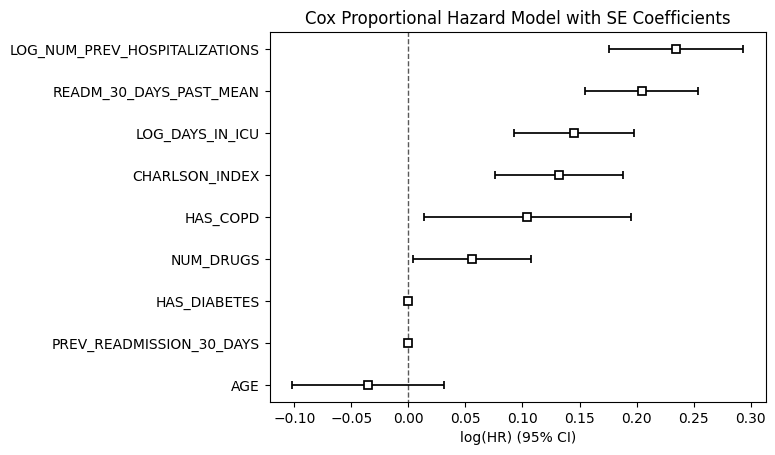

In [54]:
next_event_model_cph_se: NextEventPredictionModel = cph_se_model.model
next_event_model_cph_se.random_search_cv_results = search_results_cph_se
next_event_model_cph_se.model.print_summary()
ax = next_event_model_cph_se.model.plot()
save_coef_lifelines_plot(ax, next_event_model_cph_se)

In [ ]:
_ = next_event_model_cph_se.model.check_assumptions(
    X_train_scaled_all_events[
        features + ["EVENT_DURATION", "READMISSION_EVENT", "SUBJECT_ID"]
    ],
    p_value_threshold=0.05,
)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 4190 total observations, 2089 right-censored observations>
         test_name = proportional_hazard_test

---
                                    test_statistic      p  -log2(p)
AGE                           km              1.67   0.20      2.35
                              rank            1.67   0.20      2.35
CHARLSON_INDEX                km              0.54   0.46      1.11
                              rank            0.54   0.46      1.11
HAS_COPD                      km              1.39   0.24      2.07
                              rank            1.39   0.24      2.07
HAS_DIABETES                  km              0.08   0.77      0.37
                              rank            0.08   0.77      0.37
LOG_DAYS_IN_ICU               km              8.79 <0.005      8.37
                              rank            8.79 <0.005      8.37
LOG_NUM_PREV_HOSPITALIZATIONS km              5.39   0.02      5.62
                              rank            5.39   0.02      5.62
NUM_DRUGS                     km              0.13   0.72      0.48
                              rank            0.13   0.72      0.48
PREV_READMISSION_30_DAYS      km              0.10   0.75      0.41
                              rank            0.10   0.75      0.41
READM_30_DAYS_PAST_MEAN       km              1.17   0.28      1.84
                              rank            1.17   0.28      1.84



1. Variable 'LOG_NUM_PREV_HOSPITALIZATIONS' failed the non-proportional test: p-value is 0.0203.

   Advice 1: the functional form of the variable 'LOG_NUM_PREV_HOSPITALIZATIONS' might be incorrect.
That is, there may be non-linear terms missing. The proportional hazard test used is very sensitive
to incorrect functional forms. See documentation in link [D] below on how to specify a functional
form.

   Advice 2: try binning the variable 'LOG_NUM_PREV_HOSPITALIZATIONS' using pd.cut, and then specify
it in `strata=['LOG_NUM_PREV_HOSPITALIZATIONS', ...]` in the call in `.fit`. See documentation in
link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'LOG_DAYS_IN_ICU' failed the non-proportional test: p-value is 0.0030.

   Advice 1: the functional form of the variable 'LOG_DAYS_IN_ICU' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive

In [ ]:
next_event_model_cph_se.plot_survival_function(
    X_train_scaled_all_events.iloc[:5],
    duration_col="EVENT_DURATION",
    n=3,
    event_col="READMISSION_EVENT",
)

In [ ]:
next_event_model_cph_se.plot_survival_function(
    X_test_scaled_all_events.iloc[:6],
    duration_col="EVENT_DURATION",
    n=6,
    event_col="READMISSION_EVENT",
)

##### Evaluation Train Dataset

In [ ]:
c_index_cox_ph_all_events = next_event_model_cph_se.evaluate_c_index(
    X_train_scaled_all_events, save_metric=True, evaluation_set="train"
)
print(
    f"Train C-index for Cox Proportional Hazards Model with all events: {c_index_cox_ph_all_events:.4f}"
)

Train C-index for Cox Proportional Hazards Model with all events: 0.6151


##### Evaluation Test Dataset

In [ ]:
X_test_scaled_all_events["READM_30_DAYS_PAST_MEAN"].fillna(0, inplace=True)
next_event_model_cph_se.evaluate_c_index(
    X_test_scaled_all_events, save_metric=True, evaluation_set="test"
)

/tmp/ipykernel_6237/693151246.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





0.6166567286780661

In [ ]:
from recurrent_health_events_prediction.training.utils_survival import evaluate_model

# Evaluate the model on the test set
evaluate_model(
    next_event_model_cph_se,
    X_train_scaled_all_events,
    X_test_scaled_all_events,
    evaluation_times=evaluation_times,
    save_plots=True,
    evaluation_set="test",
)

Test C-index for Cox Proportional Hazard Model with SE: 0.6167


Mean AUC-ROC for Cox Proportional Hazard Model with SE: 0.6395


In [ ]:
from recurrent_health_events_prediction.training.utils_survival import (
    evaluate_model_around_specific_time,
)

prob_df_all_events, auc_roc_all_events = evaluate_model_around_specific_time(
    next_event_model_cph_se,
    X_test_scaled_all_events,
    evaluation_time=30,
    save_plots=True,
    evaluation_set="test",
)

In [ ]:
from recurrent_health_events_prediction.training.utils_survival import (
    plot_bad_good_predictions_event_ocurring,
)

plot_bad_good_predictions_event_ocurring(
    events_df=all_events_df,
    prob_df=prob_df_all_events,
    prob_col="survival_prob_at_t",
    features=features,
    true_event_col="true_event",
    event_id_col="HADM_ID",
    good_survival_threshold=0.5,
    bad_survival_threshold=0.6,
)

#### AFT Weibull - Last Event Features 

In [64]:
from recurrent_health_events_prediction.training.utils_survival import (
    train_next_event_survival_model_rand_search_cv,
)

aft_weibull_model_config = next_event_model_config["last_event_based"].copy()
aft_weibull_model_config["model_type"] = SurvivalModelType.WEIBULL_AFT
aft_weibull_model_config["cluster_col"] = None
aft_weibull_model_config["strata_col"] = None
aft_weibull_model_config["model_name"] = "AFT Weibull Model"

random_search_aft_weibull = train_next_event_survival_model_rand_search_cv(
    training_df=X_train_scaled,
    model_config=aft_weibull_model_config,
    strata_col_s=strata_col,
    param_grid=param_lifelines_grid,
    n_iter=n_iter,
    random_state=random_state,
    cv=cv,
)

aft_weibull_model = random_search_aft_weibull.best_estimator_

In [65]:
search_results_aft_weibull = summarize_search_results(
    random_search_aft_weibull, model_name="AFT Weibull Model"
)

10 candidates of Aft weibull model trained and validated with cross-validation on 5 folds.
Best parameters: {'model_params': {'penalizer': np.float64(0.06999999999999999), 'l1_ratio': np.float64(0.6873684210526316)}}
Validation Score - Aft weibull model: 0.707 ± 0.003


<lifelines.WeibullAFTFitter: fitted with 8616 total observations, 7109 right-censored observations>
             duration col = 'EVENT_DURATION'
                event col = 'READMISSION_EVENT'
                penalizer = 0.06999999999999999
   number of observations = 8616
number of events observed = 1507
           log-likelihood = -11036.53
         time fit was run = 2025-10-04 19:16:54 UTC

---
                                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                                  
lambda_ CHARLSON_INDEX            -0.00      1.00      0.03           -0.06            0.06                0.94                1.06
        LOG_DAYS_IN_ICU           -0.00      1.00      0.03           -0.06            0.06                0.94                1.06
        NUM_PREV_HOSPITALIZATIONS -0.18      0.84      0.01           -0.20           -0.15                0.82                0.86
        Intercept                  6.77    872.07      0.05            6.66            6.88              783.87              970.20
rho_    Intercept                 -0.19      0.82      0.02           -0.24           -0.15                0.79                0.86

                                   cmp to      z      p  -log2(p)
param   covariate                                                
lambda_ CHARLSON_INDEX               0.00  -0.00   1.00      0.00
        LOG_DAYS_IN_ICU              0.00  -0.00   1.00      0.00
        NUM_PREV_HOSPITALIZATIONS    0.00 -13.91 <0.005    143.72
        Intercept                    0.00 124.45 <0.005       inf
rho_    Intercept                    0.00  -9.03 <0.005     62.30
---
Concordance = 0.70
AIC = 22083.06
log-likelihood ratio test = -221.21 on 3 df
-log2(p) of ll-ratio test = -0.00

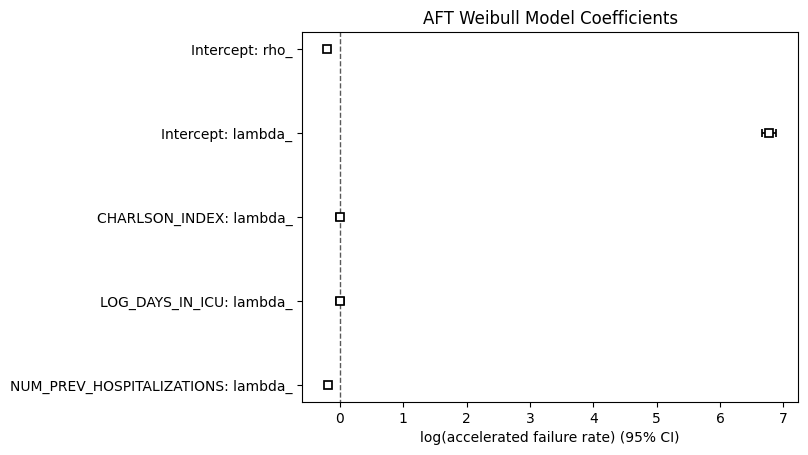

In [66]:
next_event_model_aft_weibull: NextEventPredictionModel = aft_weibull_model.model
next_event_model_aft_weibull.model.print_summary()
ax = next_event_model_aft_weibull.model.plot()
save_coef_lifelines_plot(ax, next_event_model_aft_weibull)

In [67]:
next_event_model_aft_weibull.plot_survival_function(
    X_test_scaled, duration_col="EVENT_DURATION", n=3, event_col="READMISSION_EVENT"
)

##### Evaluation Train Dataset

In [68]:
c_index_aft_weibull = next_event_model_aft_weibull.evaluate_c_index(
    X_train_scaled, save_metric=True, evaluation_set="train"
)
print(f"Train C-index for AFT Weibull Model: {c_index_aft_weibull:.4f}")

Train C-index for AFT Weibull Model: 0.6981


##### Evaluation Test Dataset

In [69]:
next_event_model_aft_weibull.evaluate_c_index(
    X_test_scaled, save_metric=True, evaluation_set="test"
)

0.7139565771665085

In [70]:
evaluate_model(
    next_event_model_aft_weibull,
    X_train_scaled,
    X_test_scaled,
    save_plots=True,
    evaluation_times=evaluation_times,
)

Test C-index for AFT Weibull Model: 0.7140


Mean AUC-ROC for AFT Weibull Model: 0.7126


In [71]:
from recurrent_health_events_prediction.training.utils_survival import (
    evaluate_model_around_specific_time,
)

prob_df = evaluate_model_around_specific_time(
    next_event_model_aft_weibull,
    X_test_scaled,
    save_plots=True,
    evaluation_time=30,
)

#### Survival GBM - Last Events

In [87]:
for col in [
    "LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN",
    "LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD",
    "LOG_DAYS_SINCE_LAST_HOSPITALIZATION",
    "READM_30_DAYS_PAST_MEAN",
    "READM_30_DAYS_PAST_SUM",
]:
    median_value = X_train[col].median()
    print(f"Median value for {col}: {median_value}")
    X_train[col] = X_train[col].fillna(median_value)
    X_test[col] = X_test[col].fillna(median_value)

Median value for LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN: 4.880763291637519
Median value for LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD: 1.2632552923995712
Median value for LOG_DAYS_SINCE_LAST_HOSPITALIZATION: 4.804339755323976
Median value for READM_30_DAYS_PAST_MEAN: 0.0
Median value for READM_30_DAYS_PAST_SUM: 0.0


In [ ]:
survival_gbm_model_config = next_event_model_config["last_event_based"].copy()
survival_gbm_model_config["model_type"] = SurvivalModelType.GBM.value
survival_gbm_model_config["cluster_col"] = None
survival_gbm_model_config["strata_col"] = None
survival_gbm_model_config["model_name"] = "Survival GBM Model"

gbm_features = [
    "AGE",
    "READM_30_DAYS_PAST_MEAN",
    "PREV_READMISSION_30_DAYS",
    "CHARLSON_INDEX",
    "LOG_NUM_PREV_HOSPITALIZATIONS",
    "LOG_DAYS_IN_ICU",
    "NUM_DRUGS",
    "HAS_DIABETES",
    "HAS_COPD",
    "RANDOM_FEATURE",
]

survival_gbm_model_config["features"] = gbm_features


random_search_survival_gbm = train_next_event_survival_model_rand_search_cv(
    training_df=X_train,
    model_config=survival_gbm_model_config,
    strata_col_s=strata_col,
    param_grid=param_grid_gbm_survival,
    n_iter=10,
    random_state=random_state,
    cv=5,
)

survival_gbm_model = random_search_survival_gbm.best_estimator_
random_search_survival_gbm

In [ ]:
search_results_survival_gbm = summarize_search_results(
    random_search_survival_gbm, model_name="Survival GBM Model"
)

10 candidates of Survival gbm model trained and validated with cross-validation on 5 folds.
Best parameters: {'model_params': {'n_estimators': 200, 'max_depth': 3, 'learning_rate': np.float64(0.03111111111111111)}}
Validation Score - Survival gbm model: 0.627 ± 0.019


In [ ]:
next_event_model_gbm: NextEventPredictionModel = survival_gbm_model.model
next_event_model_gbm.random_search_cv_results = search_results_survival_gbm

In [ ]:
next_event_model_gbm.plot_survival_function(
    X_test, n=5, event_col="READMISSION_EVENT", duration_col="EVENT_DURATION"
)

In [ ]:
from recurrent_health_events_prediction.model.utils import plot_feature_importance

filepath = next_event_model_gbm.get_model_dir() + "/feature_importance.html"
title = f"Feature Importance {next_event_model_gbm.model_name}"
plot_feature_importance(
    next_event_model_gbm.model, title=title, n=10, save_path=filepath
)

##### Evaluation Train Set

In [ ]:
c_index_gbm = next_event_model_gbm.evaluate_c_index(
    X_train, save_metric=True, evaluation_set="train"
)
print(f"Train C-index for Survival Gradient Boosting Machine Model: {c_index_gbm:.4f}")

Train C-index for Survival Gradient Boosting Machine Model: 0.6993


##### Evaluation Test Set

In [ ]:
from recurrent_health_events_prediction.training.utils_survival import evaluate_model

evaluate_model(
    next_event_model_gbm,
    X_train,
    X_test,
    evaluation_times=evaluation_times,
    evaluation_set="test",
    save_plots=True,
)

Test C-index for Survival GBM Model: 0.5643


Mean AUC-ROC for Survival GBM Model: 0.5790


In [ ]:
from recurrent_health_events_prediction.training.utils_survival import (
    evaluate_model_around_specific_time,
)

prob_df, auc_roc = evaluate_model_around_specific_time(
    next_event_model_gbm,
    X_test,
    evaluation_time=30,
    save_plots=True,
)

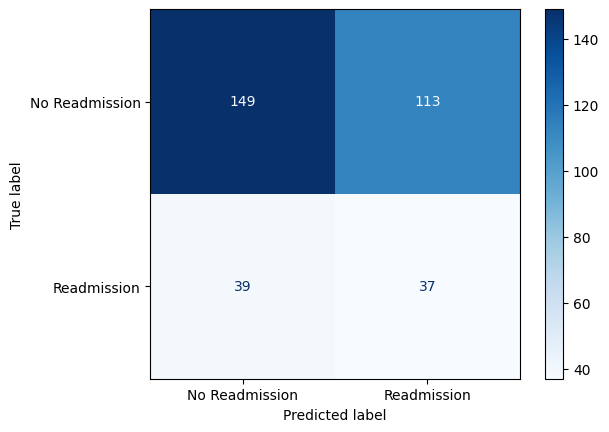

In [ ]:
from recurrent_health_events_prediction.training.utils_survival import (
    plot_confusion_matrix,
)

labels = prob_df["event_at_t"].values
scores = prob_df["prob_event_happened_before_t"].values

plot_confusion_matrix(
    labels=labels,
    scores=scores,
    threshold=0.25,
)

In [ ]:
from recurrent_health_events_prediction.training.utils_survival import (
    plot_bad_good_predictions_event_ocurring,
)

plot_bad_good_predictions_event_ocurring(
    events_df=last_events_df,
    prob_df=prob_df,
    prob_col="survival_prob_at_t",
    features=features,
    true_event_col="true_event",
    event_id_col="HADM_ID",
    good_survival_threshold=0.6,
    bad_survival_threshold=0.8,
)

#### AFT Log Normal - Last Events 

In [73]:
aft_lognormal_model_config = next_event_model_config["last_event_based"].copy()
aft_lognormal_model_config["model_type"] = SurvivalModelType.LOGNORMAL_AFT.value
aft_lognormal_model_config["cluster_col"] = None
aft_lognormal_model_config["strata_col"] = None
aft_lognormal_model_config["model_name"] = "AFT Lognormal Model"
aft_lognormal_model_config["features"] = [
    "LOG_NUM_PREV_HOSPITALIZATIONS",
    "LOG_DAYS_IN_ICU",
    "CHARLSON_INDEX",
    "READM_30_DAYS_PAST_MEAN",
]

random_search_aft_lognormal = train_next_event_survival_model_rand_search_cv(
    training_df=X_train_scaled,
    model_config=aft_lognormal_model_config,
    strata_col_s=strata_col,
    param_grid=param_lifelines_grid,
    n_iter=n_iter,
    random_state=random_state,
    cv=cv,
)

aft_lognormal_model = random_search_aft_lognormal.best_estimator_

In [74]:
search_results_aft_log_normal = summarize_search_results(
    random_search_aft_lognormal, model_name="AFT Lognormal Model"
)

4 candidates of Aft lognormal model trained and validated with cross-validation on 5 folds.
Best parameters: {'model_params': {'penalizer': np.float64(0.14), 'l1_ratio': np.float64(0.06210526315789474)}}
Validation Score - Aft lognormal model: 0.718 ± 0.007


<lifelines.LogNormalAFTFitter: fitted with 8616 total observations, 7109 right-censored observations>
             duration col = 'EVENT_DURATION'
                event col = 'READMISSION_EVENT'
                penalizer = 0.14
   number of observations = 8616
number of events observed = 1507
           log-likelihood = -11126.89
         time fit was run = 2025-10-04 19:18:10 UTC

---
                                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                                      
mu_    CHARLSON_INDEX                -0.13      0.88      0.02           -0.17           -0.09                0.84                0.91
       LOG_DAYS_IN_ICU               -0.11      0.89      0.02           -0.15           -0.07                0.86                0.93
       LOG_NUM_PREV_HOSPITALIZATIONS -0.41      0.66      0.02           -0.45           -0.38                0.64                0.69
       READM_30_DAYS_PAST_MEAN       -0.18      0.83      0.05           -0.28           -0.09                0.76                0.91
       Intercept                      6.47    646.37      0.04            6.39            6.56              593.83              703.57
sigma_ Intercept                      0.67      1.95      0.01            0.64            0.69                1.89                2.00

                                      cmp to      z      p  -log2(p)
param  covariate                                                    
mu_    CHARLSON_INDEX                   0.00  -6.27 <0.005     31.41
       LOG_DAYS_IN_ICU                  0.00  -5.58 <0.005     25.33
       LOG_NUM_PREV_HOSPITALIZATIONS    0.00 -22.06 <0.005    355.87
       READM_30_DAYS_PAST_MEAN          0.00  -3.82 <0.005     12.90
       Intercept                        0.00 149.59 <0.005       inf
sigma_ Intercept                        0.00  45.76 <0.005       inf
---
Concordance = 0.72
AIC = 22265.77
log-likelihood ratio test = -533.39 on 4 df
-log2(p) of ll-ratio test = -0.00

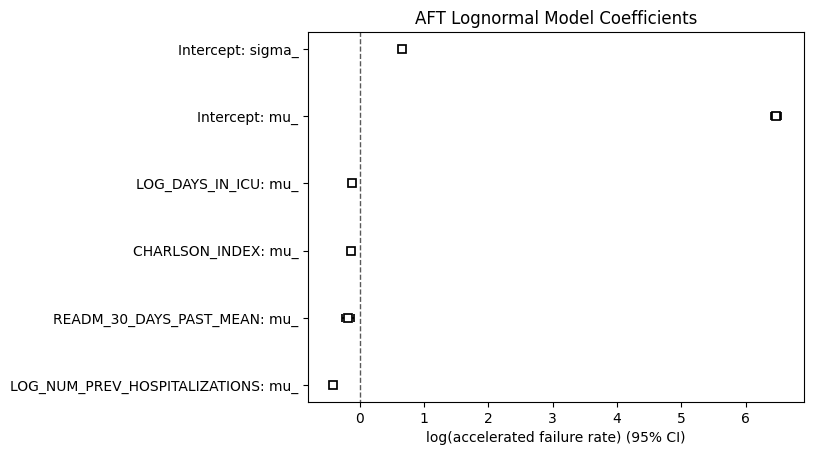

In [75]:
next_event_model_aft_log_normal: NextEventPredictionModel = aft_lognormal_model.model
next_event_model_aft_log_normal.random_search_cv_results = search_results_aft_log_normal
next_event_model_aft_log_normal.model.print_summary()
ax = next_event_model_aft_log_normal.model.plot()
save_coef_lifelines_plot(ax, next_event_model_aft_log_normal)

In [76]:
next_event_model_aft_log_normal.plot_survival_function(
    X_test_scaled, duration_col="EVENT_DURATION", n=3, event_col="READMISSION_EVENT"
)

##### Evaluation Train Set

In [77]:
c_index_log_normal_aft = next_event_model_aft_log_normal.evaluate_c_index(
    X_train_scaled, save_metric=True, evaluation_set="train"
)
print(f"Train C-index for AFT Lognormal Model: {c_index_log_normal_aft:.4f}")

Train C-index for AFT Lognormal Model: 0.7185


##### Evaluation Test Dataset

In [78]:
next_event_model_aft_log_normal.evaluate_c_index(
    X_test_scaled, save_metric=True, evaluation_set="test"
)

0.7269140697393619

In [79]:
evaluate_model(
    next_event_model_aft_log_normal,
    X_train_scaled,
    X_test_scaled,
    save_plots=True,
    evaluation_times=evaluation_times,
    evaluation_set="test",
)

Test C-index for AFT Lognormal Model: 0.7269


Mean AUC-ROC for AFT Lognormal Model: 0.7249


In [80]:
from recurrent_health_events_prediction.training.utils_survival import (
    evaluate_model_around_specific_time,
)

prob_df = evaluate_model_around_specific_time(
    next_event_model_aft_log_normal,
    X_test_scaled,
    evaluation_time=30,
    evaluation_set="test",
    save_plots=True,
)

In [81]:
search_results_aft_log_normal

{'model_name': 'AFT Lognormal Model',
 'best_score_mean': 0.7184856751921506,
 'best_score_std': 0.007144875658078472,
 'n_fitted_candidates': np.int64(4),
 'num_folds': 5,
 'best_params': {'model_params': {'penalizer': np.float64(0.14),
   'l1_ratio': np.float64(0.06210526315789474)}}}

## Final Results

In [ ]:
models = [
    next_event_model_km,
    next_event_model_cph,
    next_event_model_aft_log_normal,
    next_event_model_aft_weibull,
    next_event_model_gbm,
    next_event_model_cph_se,
]
random_search_results = [
    None,
    search_results_cph,
    search_results_aft_log_normal,
    search_results_aft_weibull,
    search_results_survival_gbm,
    search_results_cph_se,
]

for model in models:
    model.save_model()
    if model.random_search_cv_results is not None:
        model.save_random_search_cv_results()
    model.save_key_performance_metrics()
    model.save_model_params()

summary_results = {
    "Model": [],
    "Features": [],
    "C-Index": [],
    "Avg. Brier Score": [],
    "AUC 30 Days": [],
    "Avg. Time-Dependent AUC": [],
}

cross_validation_results = {
    "Model": [],
    "Num Candidates": [],
    "Folds": [],
    "Mean C-Index": [],
    "Std C-Index": [],
}

for model in models:
    summary_results["Model"].append(model.model_name)
    summary_results["Features"].append(", ".join(model.feature_names_in_))
    summary_results["C-Index"].append(model.key_test_performance_metrics["c_index"])
    summary_results["Avg. Brier Score"].append(
        model.key_test_performance_metrics["avg_brier_score"]
    )
    summary_results["AUC 30 Days"].append(
        model.key_test_performance_metrics.get("auc_roc_at_t_30", 0.5)
    )
    summary_results["Avg. Time-Dependent AUC"].append(
        model.key_test_performance_metrics["avg_cumulative_dynamic_auc"]
    )

for rand_search_result in random_search_results:
    if rand_search_result is None:
        continue
    cross_validation_results["Model"].append(rand_search_result["model_name"])
    cross_validation_results["Num Candidates"].append(
        rand_search_result["n_fitted_candidates"]
    )
    cross_validation_results["Folds"].append(rand_search_result["num_folds"])
    cross_validation_results["Mean C-Index"].append(
        rand_search_result["best_score_mean"]
    )
    cross_validation_results["Std C-Index"].append(rand_search_result["best_score_std"])

Saving model to /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/survival_last_event_based/kaplan_meier_estimator/kaplan_meier_estimator.pkl
Saving model to /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/survival_last_event_based/cox_proportional_hazard_model/cox_proportional_hazard_model.pkl
Saving model to /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/survival_last_event_based/aft_lognormal_model/aft_lognormal_model.pkl
Saving model to /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/survival_last_event_based/aft_weibull_model/aft_weibull_model.pkl
Saving model to /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/survival_last_event_based/survival_gbm_model/survival_gbm_model.pkl
Saving model to /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/survival_last_event_based/cox_proportional_hazard_model_with_se/cox_proportional_haz

In [115]:
summary_df = pd.DataFrame(summary_results)
summary_df = summary_df.sort_values(by="C-Index", ascending=False)
summary_df.reset_index(drop=True, inplace=True)
summary_df

Model  \
0  Cox Proportional Hazard Model with SE   
1                    AFT Lognormal Model   
2                      AFT Weibull Model   
3          Cox Proportional Hazard Model   
4                     Survival GBM Model   
5                 Kaplan Meier Estimator   

                                            Features   C-Index  \
0  AGE, READM_30_DAYS_PAST_MEAN, PREV_READMISSION...  0.616657   
1  LOG_NUM_PREV_HOSPITALIZATIONS, LOG_DAYS_IN_ICU...  0.584457   
2  AGE, READM_30_DAYS_PAST_MEAN, PREV_READMISSION...  0.584335   
3  AGE, READM_30_DAYS_PAST_MEAN, PREV_READMISSION...  0.582897   
4  AGE, READM_30_DAYS_PAST_MEAN, PREV_READMISSION...  0.564321   
5  AGE, READM_30_DAYS_PAST_MEAN, PREV_READMISSION...  0.500000   

   Avg. Brier Score  AUC 30 Days  Avg. Time-Dependent AUC  
0          0.200168     0.645794                 0.639507  
1          0.191556     0.608126                 0.621886  
2          0.191064     0.604259                 0.618224  
3          0.192230     0.604108                 0.616685  
4          0.197555     0.565840                 0.579000  
5          0.200058     0.500000                 0.500000

In [ ]:
cross_validation_results_df = pd.DataFrame(cross_validation_results)
cross_validation_results_df = cross_validation_results_df.sort_values(
    by="Mean C-Index", ascending=False
)
cross_validation_results_df.reset_index(drop=True, inplace=True)
cross_validation_results_df

Model  Num Candidates  Folds  Mean C-Index  \
0                    AFT Lognormal Model               7      5      0.633797   
1          Cox Proportional Hazard Model              10      5      0.630789   
2                      AFT Weibull Model              10      5      0.630383   
3                     Survival GBM Model              10      5      0.626890   
4  Cox Proportional Hazard Model with SE              10      5      0.613570   

   Std C-Index  
0     0.010197  
1     0.008323  
2     0.008564  
3     0.018679  
4     0.009968

In [ ]:
with open("search_results_cph.txt", "w") as f:
    f.write(str(random_search_cph.cv_results_))

with open("search_results_cph_se.txt", "w") as f:
    f.write(str(random_search_cph_se.cv_results_))

with open("aft_weibull_search_results.txt", "w") as f:
    f.write(str(random_search_aft_weibull.cv_results_))

with open("search_results_aft_log_normal.txt", "w") as f:
    f.write(str(random_search_aft_lognormal.cv_results_))

with open("search_results_survival_gbm.txt", "w") as f:
    f.write(str(random_search_survival_gbm.cv_results_))

summary_df.to_csv("model_summary_results.csv", index=False)
print("Model summary results saved to model_summary_results.csv")

Model summary results saved to model_summary_results.csv
